### Week 5 - More on working with climate model output
#### Doing an area-weighted spatial average of global data

The first 4 cells are repeat from last week

In [5]:
import numpy as np
import matplotlib.pyplot as py
import math
import xarray

In [12]:
#read in temperature data
filename = 'cmip6_tas.nc'
nc_file = xarray.open_dataset(filename)
tasdata = nc_file['tas'].data - 273.15 #convert to celsius
time = nc_file['time'].data
lat = nc_file['lat'].data
lon = nc_file['lon'].data
nc_file.close() #we've extracted the data we need and we can close the file

In [11]:
time

array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ...,
       '2014-10-16T12:00:00.000000000', '2014-11-16T00:00:00.000000000',
       '2014-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [3]:
#reformat the time dimension
nmonths = 12
nyears = int(len(time)/nmonths)
date = np.zeros(time.size)
for i in range(time.size):
    date[i] = 1850.0 + i/12 + 0.5

Calculate the average for every year and then weight based on the area of the respective gricell. The cells at the poles are much smaller and so we want them to have a smaller weight, compared to the tropics, when calculating the global average. 

In [4]:
tasyearmean = np.zeros((nyears, len(lat), len(lon))) #for every year, a lat x lon grid
globaltas = np.zeros(nyears) #for every year, have one global mean temperature

for t in range(nyears):
    tasyearmean[t,:,:] = np.mean(tasdata[t*12 : t*12+12, :, :], axis=0)
    globaltas[t] = np.average(tasyearmean[t, :, :]) #unweighted
    
tasfinal = tasyearmean[-1,:,:]
tasinitial = tasyearmean[0,:,:]
tasdiff = tasfinal - tasinitial

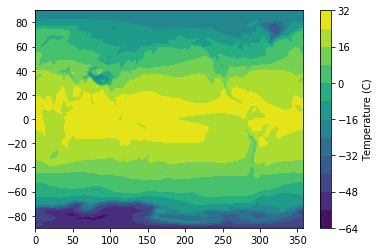

In [5]:
fig = py.figure()
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(lon, lat, tasinitial, 10)
cbar = py.colorbar(contour_plot)
cbar.set_label('Temperature (C)')

Plot the change in T from the first year to the last year

In [6]:
tasfinal = tasyearmean[-1,:,:]
tasinitial = tasyearmean[0,:,:]
tasdiff = tasfinal - tasinitial #map of change in temperature 

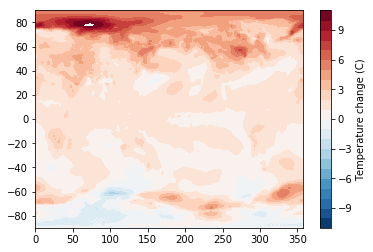

In [7]:
fig = py.figure()
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(lon, lat, tasdiff, np.arange(-11,12), cmap='RdBu_r')
cbar = py.colorbar(contour_plot)
cbar.set_label('Temperature change (C)')

So far, we have not weighted each cell by its area when calculating the global average. There are two ways to get the weights: First, using geometry of a sphere and doing a calculation for each cell. Second, using the NC file from CMIP6 which gives us the weight of each cell in a separate file.

#### First: do the geometric calculations
Each cell will have a weighted area based on its latitude. Cells closer to the poles should be smaller.

In [8]:
arealat = np.zeros(len(lat)) 
Re = 6.371e6 #radius of earth
dlat = lat[1] - lat[0]
print('lat diff =', dlat)

lat diff = 1.2676086


In [9]:
for i in range(len(lat)):
    htop = Re*(1 - math.sin(math.radians(lat[i] + dlat)))
    hbot = Re*(1 - math.sin(math.radians(lat[i] - dlat)))
    areatop = 2 * math.pi * Re * htop
    areabot = 2 * math.pi * Re * hbot
    areadiff = areabot - areatop
    arealat[i] = areadiff/len(lon)

In [10]:
arealat

array([0.00000000e+00, 1.73347204e+09, 3.46608521e+09, 5.19701234e+09,
       6.92538541e+09, 8.65037926e+09, 1.03711392e+10, 1.20868127e+10,
       1.37965806e+10, 1.54995856e+10, 1.71950146e+10, 1.88820276e+10,
       2.05597886e+10, 2.22274969e+10, 2.38843159e+10, 2.55294549e+10,
       2.71620984e+10, 2.87814378e+10, 3.03866999e+10, 3.19770893e+10,
       3.35518182e+10, 3.51100794e+10, 3.66512618e+10, 3.81744502e+10,
       3.96789543e+10, 4.11640376e+10, 4.26289734e+10, 4.40730489e+10,
       4.54955487e+10, 4.68957808e+10, 4.82730600e+10, 4.96267162e+10,
       5.09560786e+10, 5.22605009e+10, 5.35393444e+10, 5.47919833e+10,
       5.60178081e+10, 5.72162115e+10, 5.83866107e+10, 5.95284328e+10,
       6.06411189e+10, 6.17241277e+10, 6.27769225e+10, 6.37989914e+10,
       6.47898342e+10, 6.57489687e+10, 6.66758688e+10, 6.75702364e+10,
       6.84314811e+10, 6.92592336e+10, 7.00530861e+10, 7.08126525e+10,
       7.15375588e+10, 7.22274513e+10, 7.28819934e+10, 7.35008626e+10,
      

Check: What would the surface area of the Earth be if we summed up all the cells' area?

#### Second: compare with weights from the CMIP6 NC file for the area weights

In [11]:
#get area info
filename = 'area_historical.nc'
nc_file = xarray.open_dataset(filename)
areacella = nc_file['areacella'].data
nc_file.close()

print(np.sum(areacella)) #total surface area of the earth, 5.1 x 10^14 m2

510103740000000.0


In [1]:
a = ['hello', 'world']
a[0]

'hello'

In [2]:
a[0][1]

'e'

In [3]:
b = a[1]
b

'world'

In [4]:
b[2]


'r'